In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

In [ ]:
def prepareData (location: str) -> pd.DataFrame:
    """Return pandas dataframe with proper labeled columns and adjusted
    values.

    Args:
        location (str): The location directory in string form.

    Returns:
        pd.DataFrame: data file -> pandas dataframe
    """
    cols = ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
    df = pd.read_csv(location, names=cols, sep=r'\s+')
    df['pos_i'] = df['pos_i'] // 1000000
    df['pos_j'] = df['pos_j'] // 1000000
    
    return df

In [169]:
def create_chr_contact_matrix_df(data: pd.DataFrame) -> pd.DataFrame:
    """
    Create a DataFrame where rows and columns are chromosomes and
    each cell contains a symmetric contact matrix (DataFrame) between those chromosomes.

    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        pd.DataFrame: block DataFrame of contact matrices
    """
    # compute min/max per chromosome
    chr_bounds = {}
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']))

    for chr_ in chromosomes:
        max_i = data.loc[data['chr_i'] == chr_, 'pos_i'].max()
        max_j = data.loc[data['chr_j'] == chr_, 'pos_j'].max()
        min_i = data.loc[data['chr_i'] == chr_, 'pos_i'].min()
        min_j = data.loc[data['chr_j'] == chr_, 'pos_j'].min()
        chr_bounds[chr_] = (min(min_i, min_j), max(max_i, max_j))

    # initialize the block matrix as pandas dataframe
    chr_block_df = pd.DataFrame(index=chromosomes, columns=chromosomes, dtype=object)

    # fill each block/cell with sub contact matrices
    for chr_i in chromosomes:
        for chr_j in chromosomes:
            # Get bin coordinates
            min_i, max_i = chr_bounds[chr_i]
            min_j, max_j = chr_bounds[chr_j]
            row_bins = list(range(min_i, max_i + 1))
            col_bins = list(range(min_j, max_j + 1))

            # Initialize zero matrix
            mat = pd.DataFrame(0, index=row_bins, columns=col_bins)

            # Subset actual contact data for this chr pair
            subdf = data[(data['chr_i'] == chr_i) & (data['chr_j'] == chr_j)]

            for _, row in subdf.iterrows():
                i, j = row['pos_i'], row['pos_j']
                mat.at[i, j] = row['contacts']
                # Add symmetric entry if intra-chromosomal
                if chr_i == chr_j:
                    mat.at[j, i] = row['contacts']

            chr_block_df.at[chr_i, chr_j] = mat

    return chr_block_df

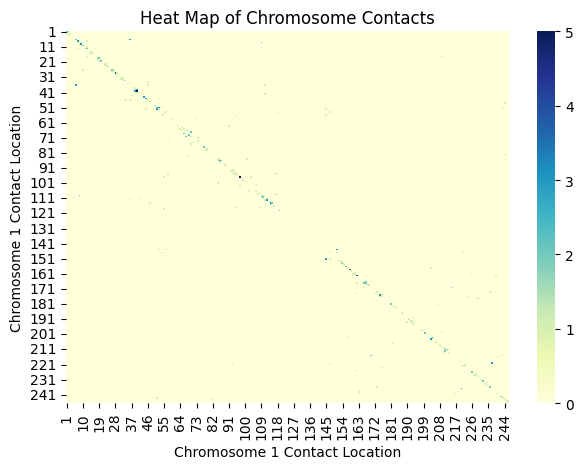

In [183]:
df = prepareData('/Users/salah/Documents/chromosome-prediction/data/ml3_AAGCGACC-ACCTCTTG.txt')
matrix = create_chr_contact_matrix_df(df)
sns.heatmap(matrix.at['chr1', 'chr1'], cmap='YlGnBu')
plt.title("Heat Map of Chromosome Contacts")
plt.xlabel("Chromosome 1 Contact Location")
plt.ylabel("Chromosome 1 Contact Location")
plt.tight_layout()
plt.show()


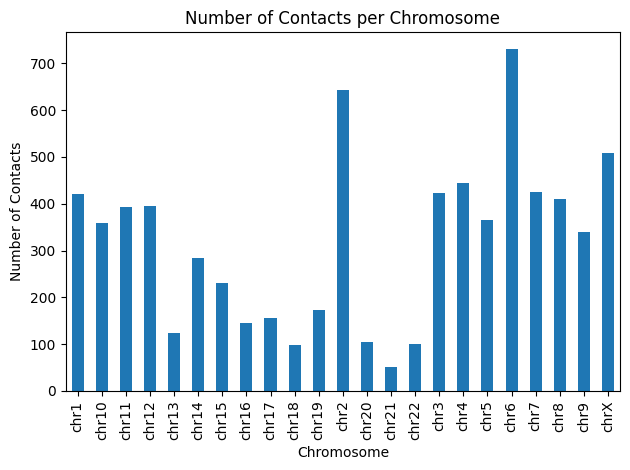

In [184]:
def chromosome_contact_histogram_data(df: pd.DataFrame) -> pd.Series:
    """
    Count total number of contacts per chromosome from both chr_i and chr_j.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['chr_i', 'chr_j']

    Returns:
        pd.Series: chromosome -> number of contacts
    """
    counts_i = df['chr_i'].value_counts()
    counts_j = df['chr_j'].value_counts()
    
    total_counts = counts_i.add(counts_j, fill_value=0).astype(int)
    return total_counts.sort_index()

contact_counts = chromosome_contact_histogram_data(df)

contact_counts.plot(kind='bar')
plt.title("Number of Contacts per Chromosome")
plt.xlabel("Chromosome")
plt.ylabel("Number of Contacts")
plt.tight_layout()
plt.show()

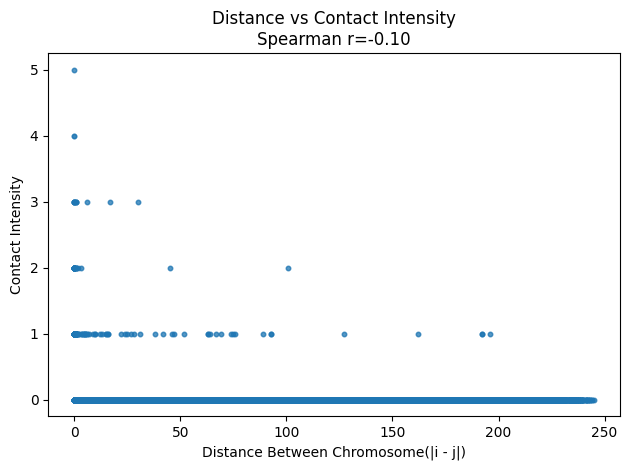

In [191]:
def distance_vs_contact_analysis(matrix: pd.DataFrame) -> dict:
    """
    Compute distance-from-diagonal vs contact intensity for a symmetric matrix.

    Args:
        matrix (pd.DataFrame): contact matrix (e.g., chr3 vs chr3)

    Returns:
        dict: {
            'distances': list of |i - j| in bins,
            'contacts': corresponding contact intensities,
            'spearman_corr': Spearman correlation (distance vs contact),
            'pearson_corr': Pearson correlation (distance vs contact)
        }
    """
    distances = []
    contacts = []

    idx_to_pos = list(matrix.index)
    col_to_pos = list(matrix.columns)

    for i, row_pos in enumerate(idx_to_pos):
        for j, col_pos in enumerate(col_to_pos):
            contact = matrix.iat[i, j]
            dist = abs(i - j) 
            distances.append(dist)
            contacts.append(contact)

    # Correlation analysis
    spearman_corr, _ = spearmanr(distances, contacts)
    pearson_corr, _ = pearsonr(distances, contacts)

    return {
        'distances': distances,
        'contacts': contacts,
        'spearman_corr': spearman_corr,
        'pearson_corr': pearson_corr
    }

submatrix = matrix.at['chr1', 'chr1']  # or any other chromosome
result = distance_vs_contact_analysis(submatrix)

plt.scatter(result['distances'], result['contacts'], alpha=0.5, s=10)
plt.title(f"Distance vs Contact Intensity\nSpearman r={result['spearman_corr']:.2f}")
plt.xlabel("Distance Between Chromosome(|i - j|)")
plt.ylabel("Contact Intensity")
plt.tight_layout()
plt.show()